In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

## 1. Load expression data

The `transformation` value can be one of `"none"`, `"sqrt"` or `"log"`, which determines how the expression data should be transformed in order to reduce outlier influence.

In [3]:
data_path: str = "data/processed_data/floral_transition.csv"
transformation: str = "sqrt"

In [4]:
from my_gatai import Expression_data

expression_data = Expression_data.from_csv(data_path, 
                                           transformation=transformation)
expression_data.full

,Phylostratum,GeneID,Zygote,Quadrant,Globular,Heart,Torpedo,Bent,Mature
0,0.665923,AT1G01040,46.622261,43.717275,33.949305,35.936367,31.626776,31.031874,41.187710
1,0.665923,AT1G01050,38.742923,42.629902,40.808196,39.557063,38.682304,33.386278,32.736150
2,0.749960,AT1G01070,34.825174,35.114132,30.646371,30.489662,29.397585,29.617664,29.913524
3,0.665923,AT1G01080,31.889188,30.600388,34.370600,36.461945,37.318130,35.888363,29.347240
4,0.665923,AT1G01090,106.885765,129.530570,185.382441,199.438313,237.131965,258.805656,88.162133
...,...,...,...,...,...,...,...,...,...
25091,0.665923,AT5G67200,26.854044,27.040926,28.086174,28.551458,29.521344,28.450039,27.369738
25092,0.994581,AT5G67245,33.657245,33.846884,32.106736,33.801105,34.283401,31.399114,33.871245
25093,0.665923,AT5G67280,27.049554,27.362177,26.552473,24.954160,27.031439,29.399112,27.821769
25094,0.665923,AT5G67380,121.347014,49.264272,49.631007,48.943978,42.984521,44.090639,71.679342


In [5]:
expression_data.p_matrix

,Zygote,Quadrant,Globular,Heart,Torpedo,Bent,Mature
0,0.000031,0.000029,0.000023,0.000024,0.000022,0.000021,0.000027
1,0.000026,0.000029,0.000028,0.000027,0.000026,0.000023,0.000022
2,0.000026,0.000027,0.000023,0.000023,0.000023,0.000023,0.000022
3,0.000021,0.000021,0.000023,0.000025,0.000026,0.000024,0.000020
4,0.000072,0.000087,0.000125,0.000136,0.000162,0.000175,0.000059
...,...,...,...,...,...,...,...
25091,0.000018,0.000018,0.000019,0.000019,0.000020,0.000019,0.000018
25092,0.000034,0.000034,0.000032,0.000034,0.000035,0.000032,0.000034
25093,0.000018,0.000018,0.000018,0.000017,0.000018,0.000020,0.000018
25094,0.000081,0.000033,0.000034,0.000033,0.000029,0.000030,0.000048


In [6]:
expression_data.tai

Zygote      0.723811
Quadrant    0.724035
Globular    0.722891
Heart       0.722849
Torpedo     0.722242
Bent        0.721885
Mature      0.723657
dtype: float64

### 1.1 Compute TAI value

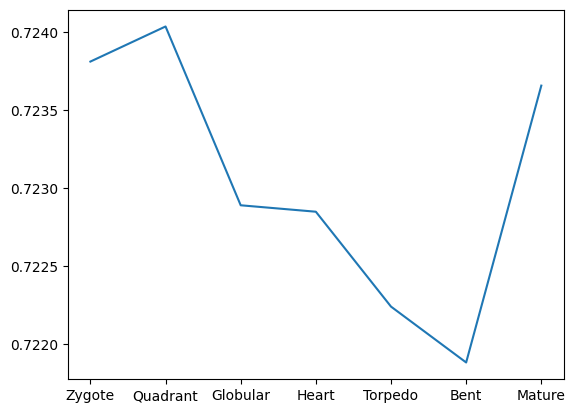

In [7]:
import matplotlib.pyplot as plt

plt.plot(expression_data.tai)
plt.show()

## 2. Flatline test

### 2.1. Compute variance of TAI curve

In [8]:
import numpy as np
tai_var = np.var(expression_data.tai).item()
tai_var

5.704724792574984e-07

### 2.2. Compute permutation variance distribution

Permute the assigned gene ages between the genes to run the flat line test

In [9]:
from gatai.utils import comp_vars

num_permutations = 10000
permutation_comp_vars = comp_vars(expression_data, num_permutations)

Running permuations


100%|██████████| 10000/10000 [00:04<00:00, 2280.91it/s]


### 2.3. Fit the random variances to a Gamma distribution and compute the p-value of the true TAI

In [10]:
from flatline import fit_gamma, p_value_function

# NOTE: the default fitting method used by scipy doesn't achieve a very good fit, so use "MM"
a, loc, scale = fit_gamma(permutation_comp_vars)
get_p_value = p_value_function(a, loc, scale)
print("Gamma fit params:", a, loc, scale)

Gamma fit params: 0.9503020056389104 4.444545344829824e-09 2.9430217781594165e-08


In [11]:
print("p-value of TAI:", get_p_value(tai_var))

p-value of TAI: 3.7069777135536245e-09


### 2.4. Visually compare the random TAI variances against the true one

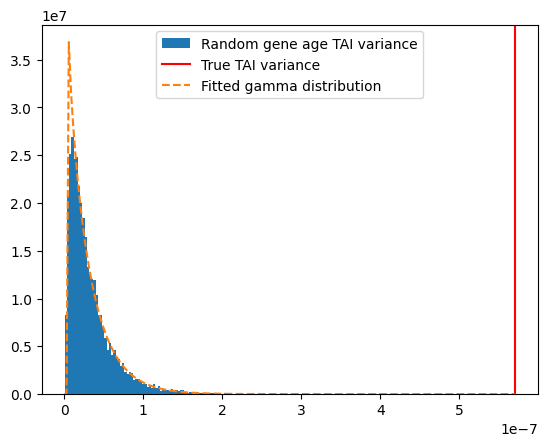

In [12]:
from scipy import stats
plt.hist(permutation_comp_vars, density=True, bins=100, label="Random gene age TAI variance")
plt.axvline(x=tai_var, label="True TAI variance", color="red")

x = np.linspace(0, tai_var, 200)
y = stats.gamma.pdf(x, a, loc=loc, scale=scale)
plt.plot(x, y, label="Fitted gamma distribution", linestyle="dashed")

plt.legend()
plt.show()

## 3. Destroy TAI signal with GATAI

### 3.1 Run genetic algorithm to extract genes that break the pattern
Note that the transformation used for the expression data heavily influences the number of genes that get extracted, as well as the number of generations needed for convergence.

Also, with transformations applied, older genes are better represented

In [39]:
from my_gatai import get_extracted_genes
from concurrent.futures import ThreadPoolExecutor

num_runs = 5

ga_gene_sets = []

for _ in range(num_runs):
    ga_gene_sets.append(get_extracted_genes(expression_data, permutation_comp_vars))

/Users/2648894/Library/Caches/pypoetry/virtualenvs/gatai-reproduction-YJP4mtSF-py3.12/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/2648894/Library/Caches/pypoetry/virtualenvs/gatai-reproduction-YJP4mtSF-py3.12/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	island	Num removed	Variance
0  	      	2          	1.97998 
10 	1     	571        	1.67753 
10 	2     	452        	1.71    
10 	3     	349        	1.78963 
10 	4     	358        	1.87595 


20 	1     	470        	1.54512 
20 	2     	584        	1.54185 
20 	3     	814        	1.55874 
20 	4     	528        	1.68755 


30 	1     	1009       	1.50506 
30 	2     	540        	1.49452 
30 	3     	646        	1.46622 
30 	4     	804        	1.51929 


40 	1     	637        	1.46004 
40 	2     	974        	1.45687 
40 	3     	635        	1.44368 
40 	4     	724        	1.44593 


50 	1     	597        	1.43131 
50 	2     	790        	1.37736 
50 	3     	821        	1.40143 
50 	4     	522        	1.44846 


60 	1     	745        	1.39352 
60 	2     	862        	1.34112 
60 	3     	901        	1.35701 
60 	4     	979        	1.3686  


70 	1     	1005       	1.29833 
70 	2     	1139       	1.31524 
70 	3     	943        	1.33186 
70 	4     	1082       	1.32273 


80 	1     	1001       	1.2

/Users/2648894/Library/Caches/pypoetry/virtualenvs/gatai-reproduction-YJP4mtSF-py3.12/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/2648894/Library/Caches/pypoetry/virtualenvs/gatai-reproduction-YJP4mtSF-py3.12/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	island	Num removed	Variance
0  	      	5          	1.98782 
10 	1     	338        	1.73606 
10 	2     	549        	1.63116 
10 	3     	473        	1.70521 
10 	4     	368        	1.85316 


20 	1     	456        	1.67849 
20 	2     	573        	1.55689 
20 	3     	811        	1.54571 
20 	4     	1025       	1.58477 


30 	1     	1314       	1.40714 
30 	2     	1264       	1.43427 
30 	3     	912        	1.50565 
30 	4     	783        	1.51905 


40 	1     	1370       	1.36733 
40 	2     	1366       	1.35048 
40 	3     	1264       	1.39547 
40 	4     	1439       	1.40601 


50 	1     	1326       	1.36218 
50 	2     	1390       	1.35527 
50 	3     	1669       	1.32768 
50 	4     	1660       	1.32784 


60 	1     	1156       	1.28299 
60 	2     	1442       	1.30368 
60 	3     	1624       	1.29533 
60 	4     	1431       	1.3068  


70 	1     	1425       	1.27353 
70 	2     	1117       	1.28178 
70 	3     	1275       	1.27572 
70 	4     	1638       	1.27431 


80 	1     	1379       	1.2

/Users/2648894/Library/Caches/pypoetry/virtualenvs/gatai-reproduction-YJP4mtSF-py3.12/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/2648894/Library/Caches/pypoetry/virtualenvs/gatai-reproduction-YJP4mtSF-py3.12/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	island	Num removed	Variance
0  	      	3          	1.99276 
10 	1     	573        	1.61608 
10 	2     	241        	1.69999 
10 	3     	476        	1.70001 
10 	4     	373        	1.89631 


20 	1     	751        	1.5635  
20 	2     	756        	1.54788 
20 	3     	772        	1.57025 
20 	4     	606        	1.64015 


30 	1     	792        	1.50944 
30 	2     	785        	1.50501 
30 	3     	933        	1.48553 
30 	4     	875        	1.52585 


40 	1     	1006       	1.40701 
40 	2     	926        	1.4209  
40 	3     	541        	1.47057 
40 	4     	1130       	1.43352 


50 	1     	758        	1.40786 
50 	2     	854        	1.32516 
50 	3     	1023       	1.38255 
50 	4     	1252       	1.39423 


60 	1     	825        	1.36679 
60 	2     	816        	1.34352 
60 	3     	828        	1.31503 
60 	4     	1197       	1.30445 


70 	1     	1054       	1.29943 
70 	2     	1049       	1.29665 
70 	3     	1125       	1.29983 
70 	4     	904        	1.29006 


80 	1     	1053       	1.2

/Users/2648894/Library/Caches/pypoetry/virtualenvs/gatai-reproduction-YJP4mtSF-py3.12/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/2648894/Library/Caches/pypoetry/virtualenvs/gatai-reproduction-YJP4mtSF-py3.12/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	island	Num removed	Variance
0  	      	3          	1.97443 
10 	1     	345        	1.7285  
10 	2     	358        	1.76498 
10 	3     	352        	1.75697 
10 	4     	605        	1.87508 


20 	1     	552        	1.5322  
20 	2     	429        	1.63367 
20 	3     	684        	1.66588 
20 	4     	574        	1.72049 


30 	1     	971        	1.56733 
30 	2     	737        	1.51994 
30 	3     	517        	1.52639 
30 	4     	642        	1.61253 


40 	1     	907        	1.48327 
40 	2     	705        	1.50035 
40 	3     	840        	1.47363 
40 	4     	813        	1.49747 


50 	1     	891        	1.40774 
50 	2     	882        	1.4128  
50 	3     	976        	1.44693 
50 	4     	945        	1.46565 


60 	1     	657        	1.41286 
60 	2     	958        	1.40051 
60 	3     	866        	1.38628 
60 	4     	1091       	1.38667 


70 	1     	909        	1.34841 
70 	2     	1184       	1.36192 
70 	3     	636        	1.38714 
70 	4     	818        	1.3654  


80 	1     	886        	1.3

/Users/2648894/Library/Caches/pypoetry/virtualenvs/gatai-reproduction-YJP4mtSF-py3.12/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/2648894/Library/Caches/pypoetry/virtualenvs/gatai-reproduction-YJP4mtSF-py3.12/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	island	Num removed	Variance
0  	      	4          	1.99421 
10 	1     	464        	1.67107 
10 	2     	673        	1.63982 
10 	3     	348        	1.7744  
10 	4     	475        	1.87965 


20 	1     	568        	1.57556 
20 	2     	432        	1.65823 
20 	3     	632        	1.58222 
20 	4     	858        	1.57503 


30 	1     	667        	1.4761  
30 	2     	648        	1.54456 
30 	3     	769        	1.53895 
30 	4     	735        	1.54843 


40 	1     	639        	1.49552 
40 	2     	731        	1.45745 
40 	3     	975        	1.45536 
40 	4     	859        	1.50051 


50 	1     	845        	1.43759 
50 	2     	803        	1.40119 
50 	3     	807        	1.42006 
50 	4     	927        	1.39909 


60 	1     	999        	1.35817 
60 	2     	851        	1.37199 
60 	3     	1152       	1.37707 
60 	4     	911        	1.38011 


70 	1     	1061       	1.34322 
70 	2     	1061       	1.34117 
70 	3     	1229       	1.33904 
70 	4     	951        	1.36918 


80 	1     	1209       	1.3

#### Genes extracted

Select the genes which have occured in a majority of the runs

In [40]:
from collections import Counter

majority_num = num_runs / 2 + 1

c = Counter()
for s in ga_gene_sets:
    for g in s:
        c[g] += 1

ga_genes = [k for k, v in c.items() if v >= majority_num]

In [46]:
[len(s) for s in ga_gene_sets]

[204, 174, 186, 179, 182]

In [41]:
len(ga_genes)

101

In [47]:
ga_genes

['AT1G01090',
 'AT1G12230',
 'AT1G17410',
 'AT1G31330',
 'AT1G43800',
 'AT1G74960',
 'AT1G78500',
 'AT2G05990',
 'AT2G18340',
 'AT2G18540',
 'AT2G21660',
 'AT2G29980',
 'AT3G55440',
 'AT3G55800',
 'AT3G60750',
 'AT4G11320',
 'AT4G27440',
 'AT5G14320',
 'AT5G28460',
 'AT5G46290',
 'AT1G09750',
 'AT1G61520',
 'AT4G10340',
 'AT5G54270',
 'AT4G25140',
 'AT5G08040',
 'AT1G16730',
 'AT3G27660',
 'AT4G30880',
 'AT5G17460',
 'AT5G48350',
 'AT5G52300',
 'AT5G53650',
 'AT5G66580',
 'AT1G44608',
 'AT2G35300',
 'AT3G17150',
 'AT4G18740',
 'AT4G28330',
 'AT4G32105',
 'AT5G51210',
 'AT5G55410',
 'AT1G07985',
 'AT4G20880',
 'AT2G16900',
 'AT2G42560',
 'AT4G27170',
 'AT5G54740',
 'AT1G09370',
 'AT1G12845',
 'AT1G56100',
 'AT3G15280',
 'AT4G27140',
 'AT4G27150',
 'AT5G24980',
 'AT5G44005',
 'AT1G17510',
 'AT1G56415',
 'AT1G71470',
 'AT2G02515',
 'AT2G20465',
 'AT2G30560',
 'AT2G43530',
 'AT3G06090',
 'AT3G17160',
 'AT3G17520',
 'AT3G24510',
 'AT3G49270',
 'AT3G49300',
 'AT3G50970',
 'AT4G29285',
 'AT5G

### 3.2 Check variance of destroyed TAI and its new p-value

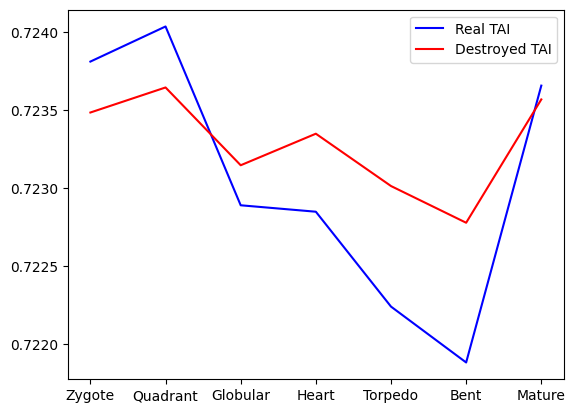

In [48]:
new_data = expression_data.remove_genes(ga_genes)
plt.plot(expression_data.tai, label="Real TAI", color="blue")
plt.plot(new_data.tai, label="Destroyed TAI", color="red")

plt.legend()
plt.show()

In [49]:
new_tai_var = np.var(new_data.tai).item()
print("destroyed TAI p-value:", get_p_value(new_tai_var))

destroyed TAI p-value: 0.056857139977673096


In [50]:
tais_per_set = []
for i in range(num_runs):
    new_data_per_set = expression_data.remove_genes(ga_gene_sets[i])
    tais_per_set.append(np.var(new_data_per_set.tai).item())

print(tais_per_set)

[1.6116322634516236e-08, 2.6046789094202786e-08, 2.10267017359885e-08, 2.0062498370756884e-08, 2.1371248204660408e-08]


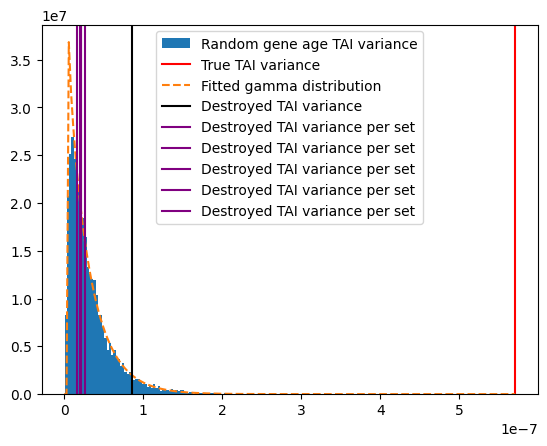

In [51]:
plt.hist(permutation_comp_vars, density=True, bins=100, label="Random gene age TAI variance")
plt.axvline(x=tai_var, label="True TAI variance", color="red")


x = np.linspace(0, tai_var, 200)
y = stats.gamma.pdf(x, a, loc=loc, scale=scale)
plt.plot(x, y, label="Fitted gamma distribution", linestyle="dashed")
plt.axvline(x=new_tai_var, label="Destroyed TAI variance", color="black")
for t in tais_per_set:
    plt.axvline(x=t, label="Destroyed TAI variance per set", color="purple")
plt.legend()
plt.show()

### 3.3 Benchmark GA against greedy removal of genes with highest variance

In [52]:
gene_variances = expression_data.gene_variances.sort_values('Variance', ascending=False)
gene_variances

,Phylostratum,GeneID,Variance
22625,0.979001,AT2G30560,6843.386327
23426,0.994581,AT1G03106,6330.254124
19986,0.979001,AT1G32560,6055.077971
13900,0.954933,AT4G36600,5833.021106
21773,0.937799,AT2G42560,5562.334849
...,...,...,...
7009,0.665923,AT5G02080,0.012863
11434,0.665923,AT2G36740,0.012674
11964,0.665923,AT3G08505,0.011695
20844,0.930387,AT4G10420,0.010001


In [35]:
k_top = len(ga_genes)

highest_var_genes = gene_variances.head(k_top)['GeneID'].to_numpy()

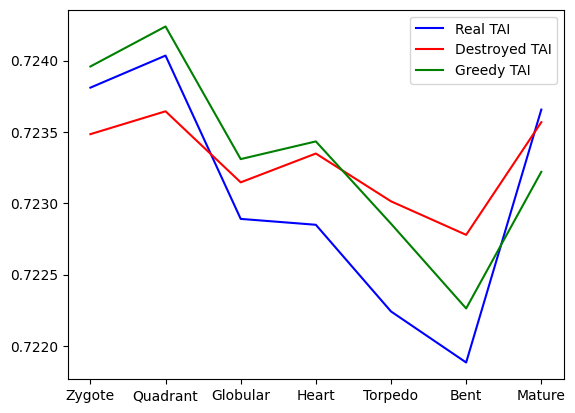

In [53]:
greedy_data = expression_data.remove_genes(highest_var_genes)
plt.plot(expression_data.tai, label="Real TAI", color="blue")
plt.plot(new_data.tai, label="Destroyed TAI", color="red")
plt.plot(greedy_data.tai, label="Greedy TAI", color="green")

plt.legend()
plt.show()

In [54]:
greedy_tai_var = np.var(greedy_data.tai).item()
print("p-value: ", get_p_value(greedy_tai_var))

p-value:  3.170522165730775e-06


Conversely, however, the genes that were extracted by GATAI tend to have a high variance (but they need to be carefully selected, it's not as simple as picking the most variant ones, hence the need for the GA approach)

In [55]:
common_genes = np.intersect1d(ga_genes, highest_var_genes)

print("Number of GA selected genes which are also part of the top_k most variant subset of genes in the dataset:", len(common_genes), "out of", len(ga_genes))

Number of GA selected genes which are also part of the top_k most variant subset of genes in the dataset: 36 out of 101
